# Cell assembly analyses

In [181]:
import itertools
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import os
import assembly
import pandas as pd
import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

## load example data

In [ ]:
# mat = scipy.io.loadmat('D:/ryanh/github/RnR_methods/data/20170505_396um_0um_merge/20170505_396um_0um_merge.CA1Ripples.events.mat')
# spikes = mat['spikes'][0][0][1][0]

In [182]:
# output files are saved here
save_path = 'F:/Projects/PAE_PlaceCell/analysis/cell_assembly/'
# where base data will be read in from
data_path = 'F:/Projects/PAE_PlaceCell/ProcessedData/'
# where spike times will be read in
spike_path = 'F:/Projects/PAE_PlaceCell/analysis/spikes/'
# data frame contain info for each unit
df_cell_class = pd.read_csv('F:/Projects/PAE_PlaceCell/analysis/cell_recruitment/processed/pyr_int_df.csv')


session = 'LEM3124_S20190302163218'

In [ ]:
def run_all(session,spike_path):
    
    # load spikes & add to object
    spikes = np.load(os.path.join(spike_path,session)+'.npy',allow_pickle=True)
    spikes_ = list(itertools.chain(*spikes))
    session_bounds = nel.EpochArray([min(spikes_),max(spikes_)])
    st = nel.SpikeTrainArray(timestamps=spikes,support=session_bounds, fs=32000)
    
    # bin spike data
    dt = 0.025
    binned_st = st.bin(ds=dt)
    
    # detect assemblies
    patterns, significance, zactmat = assembly.runPatterns(binned_st.data)
    assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)
    
def main_loop(session,spike_path,save_path):
    base = os.path.basename(session)
    os.path.splitext(base)
    save_file = save_path + os.path.splitext(base)[0] + '.pkl'
    
    # check if saved file exists
    if os.path.exists(save_file):
        return
        
    # detect ripples and calc some features
    results = run_all(session,spike_path)   

    # save file
    with open(save_file, 'wb') as f:
        pickle.dump(results, f)


# find sessions to run
sessions = pd.unique(df_cell_class.session)

# for session in sessions:
#     print(session)
#     main_loop(session,data_path,spike_path,save_path,df_swr,df_cell_class)
 
num_cores = multiprocessing.cpu_count()         
processed_list = Parallel(n_jobs=num_cores)(delayed(main_loop)(session,spike_path,save_path) for session in sessions)

## bin spikes

In [18]:
import nelpy as nel
import nelpy.io
import nelpy.plotting as npl

# load spikes & add to object
spikes = np.load(os.path.join(spike_path,session)+'.npy',allow_pickle=True)
spikes_ = list(itertools.chain(*spikes))

session_bounds = nel.EpochArray([min(spikes_),max(spikes_)])
st = nel.SpikeTrainArray(timestamps=spikes,support=session_bounds, fs=32000)

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:709: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_eventarray.py:996: UserWarning: ignoring events outside of eventarray support


In [97]:
dt = 0.02
binned_st = st.bin(ds=0.02)

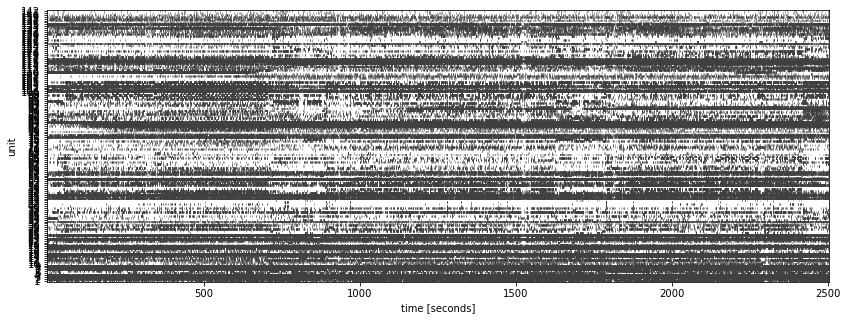

In [19]:
fig, ax = plt.subplots(ncols=1, figsize=(14,5))
npl.rasterplot(st, lw=0.5, ax=ax)
ax.set_xlabel('time [seconds]')
ax.set_ylabel('unit')
ax.set_xlim(*session_bounds.time);

In [177]:
patterns, significance, zactmat = assembly.runPatterns(binned_st.data)

In [178]:
assemblyAct = assembly.computeAssemblyActivity(patterns,zactmat)

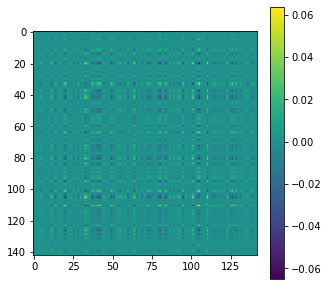

In [35]:
plt.figure(figsize=(5,5))
projMat = np.corrcoef(significance.components_,rowvar=False)
projMat -= True*np.diag(np.diag(projMat))
plt.imshow(projMat)
plt.colorbar()

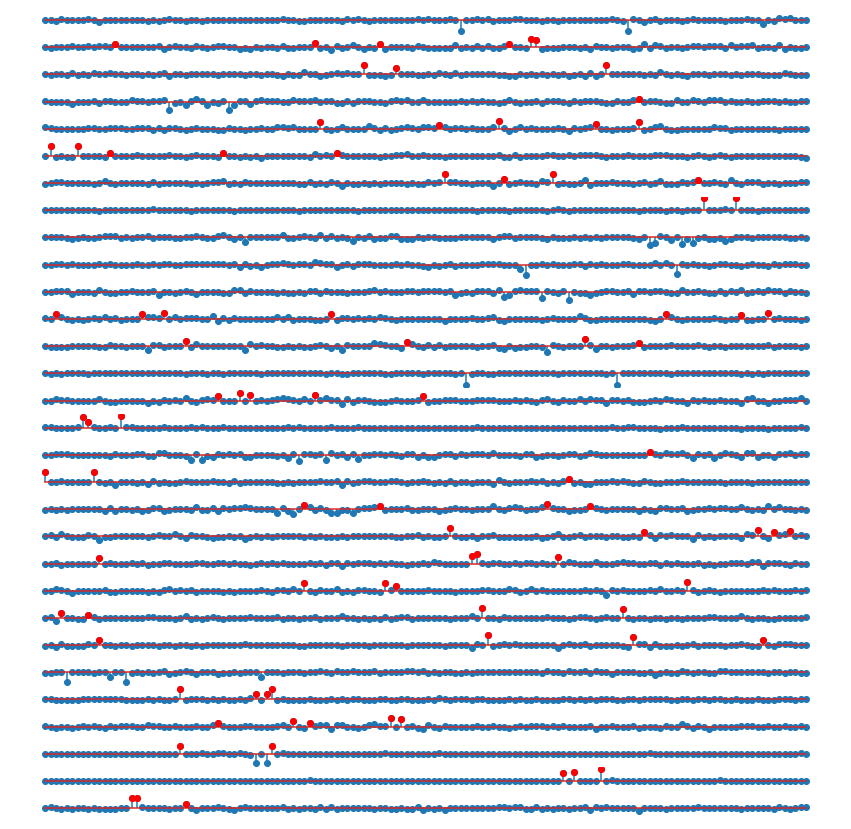

In [179]:
fig, axs = plt.subplots(patterns.shape[0],1, figsize=(15, 15), edgecolor='k')
fig.subplots_adjust(hspace = 0.00, wspace=0)
axs = axs.ravel()


for i,assmbl in enumerate(patterns):
    axs[i].stem(np.arange(len(assmbl)),assmbl)
    thres = np.mean(assmbl) + np.std(assmbl)*2
    idx = assmbl > thres
    axs[i].scatter(np.arange(len(assmbl))[idx],assmbl[idx],color='red',zorder=1000)
    
for i in range(patterns.shape[0]):
    axs[i].set_ylim(-patterns.max()-.1,patterns.max()+.1)
    axs[i].axis('off')

In [109]:
assembly_act = nel.AnalogSignalArray(assemblyAct, timestamps=binned_st.bin_centers,fs=1/dt)
assembly_act

<AnalogSignalArray at 0x28c4b12cbb0: 30 signals> for a total of 41:40:120 minutes

D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:420: UserWarning: creating support from abscissa_vals and sampling rate, fs!
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\utils.py:842: UserWarning: some steps in the data are smaller than the requested step size.
D:\ryanh\Anaconda3\envs\replay\lib\site-packages\nelpy\core\_analogsignalarray.py:861: UserWarning: ignoring signal outside of support


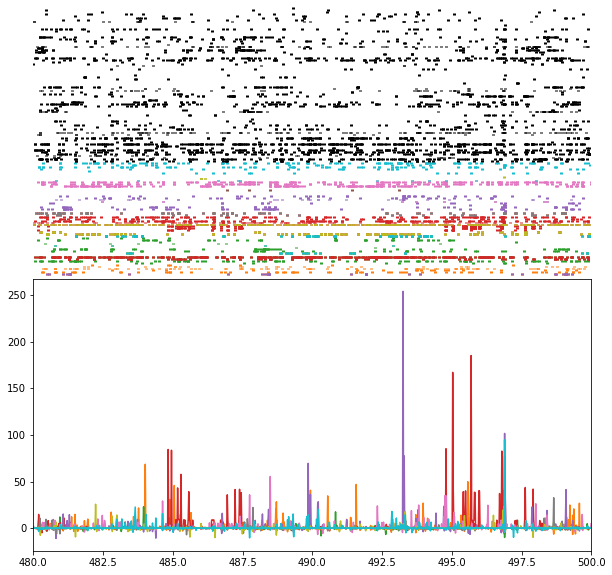

In [175]:
import matplotlib

def plot_assembl_strength(binned_st,st,patterns,assembly_act,interval,show_not_in_assmbl=True):
    
    fig, axs = plt.subplots(2,1, figsize=(10, 10), edgecolor='k')
    fig.subplots_adjust(hspace = 0.00, wspace=0)
    axs = axs.ravel()

    cmap = matplotlib.cm.get_cmap('tab10',patterns.shape[0])

    interval = nel.EpochArray(interval)
    st = st[interval]
    st.get_event_firing_order()

    assembly_act = assembly_act[interval]
    binned_st = binned_st[interval]

    assmbl_unit_id = []
    assmbl_unit_id_store = []
    for i,assmbl in enumerate(patterns):
        thres = np.mean(assmbl) + np.std(assmbl)*2
        assmbl_unit_id = np.where(assmbl > thres)
        assmbl_unit_id_store.append(assmbl_unit_id[0])
        
        if assmbl_unit_id[0].size > 0:
            npl.rasterplot(st[:,assmbl_unit_id[0]+1], lw=3,color=cmap(i), ax=axs[0], vertstack=True)
            
            axs[1].plot(binned_st.bin_centers,assembly_act.data[i,:], color=cmap(i))

    # plot units not an assmbl
    assmbl_unit_id_store_ = list(itertools.chain(*assmbl_unit_id_store))
    not_in_assmbl = np.where([val not in assmbl_unit_id_store_ for val in np.arange(st.n_units)])
    npl.rasterplot(st[:,not_in_assmbl[0]+1], lw=3,color='k', ax=axs[0], vertstack=True)
    
    axs[0].set_xlim(interval.data[0][0],interval.data[0][1])
    axs[1].set_xlim(interval.data[0][0],interval.data[0][1])

    axs[0].axis('off')
    
plot_assembl_strength(binned_st,st,patterns,assembly_act,[480,500])

    # axs[0].set_xlim(*session_bounds.time)
    # axs[1].set_xlim(*session_bounds.time)


#     axs[0].set_xlim(757,758.5)
#     axs[1].set_xlim(757,758.5)

#     axs[1].set_ylim(-4,100)

(0.0, 300.0)

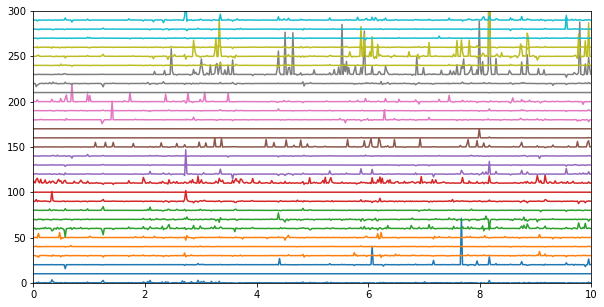

In [199]:
plt.figure(figsize=(10,5))
cmap = matplotlib.cm.get_cmap('tab10',assembly_act.n_signals)

for i in range(assembly_act.n_signals):
    plt.plot(binned_st.bin_centers,assembly_act.data[i,:] + i*10, color=cmap(i))
plt.xlim(0,10)
plt.ylim(0,300)

(0.0, 100.0)

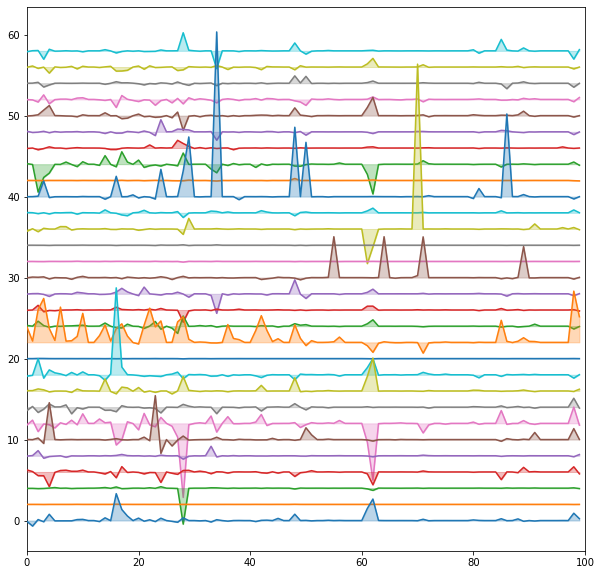

In [214]:
ratemap = assembly_act.data[:,0:100]
pad = 2
color=None
fill=True
xmin = 0 
xmax = ratemap.shape[1]
xvals = np.arange(ratemap.shape[1])
n_units = ratemap.shape[0]
# if unit_labels is None:
#     unit_labels = ratemap.unit_labels
# ratemap = ratemap.ratemap
  
fig, ax = plt.subplots(figsize=(10, 10), edgecolor='k')


for unit, curve in enumerate(ratemap):
    if color is None:
        line = ax.plot(xvals, unit*pad + curve, zorder=int(10+2*n_units-2*unit))
    else:
        line = ax.plot(xvals, unit*pad + curve, zorder=int(10+2*n_units-2*unit), color=color)
    if fill:
        # Get the color from the current curve
        fillcolor = line[0].get_color()
        ax.fill_between(xvals, unit*pad, unit*pad + curve, alpha=0.3, color=fillcolor, zorder=int(10+2*n_units-2*unit-1))
        
ax.set_xlim(xmin, xmax)


In [ ]:
axs[1].plot(binned_st.bin_centers,assembly_act.data[i,:], color=cmap(i))


In [ ]:
# Assembly reactivation strength during SPW-R periods

# Assembly strength was defined as the mean activation strength of all events (R > 5)
# across single postexploration sessions occurring during time periods detected as
# sharp wave ripples (described above).

In [ ]:
# fraction of active assemblies active during spw-r

# Activation of multiple assemblies within
# single ripple events were quantified as the number active, as a fraction of the total
# number identified for that session.

In [ ]:
# multi-assembly strength

In [ ]:
# multi-assembly rate